In [4]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [164]:
import pandas as pd

## Functions

In [196]:
# convert an HDF5 object reference or dataset to a string
def to_string(obj, f):
    if not isinstance(obj, h5py.Dataset):
        obj = f[obj]
    return ''.join([chr(int(i)) for i in obj[()]])

# window, stride in ms
# requires spike times to be sorted in increasing order!!
def spike_times_to_firing_rate(spike_times, window=50, stride=10, test_duration=None, progress_bar=False):
    if stride is None:
        stride = window
    if stride <= 0:
        stride = window
    
    window = window*0.001
    stride = stride*0.001
    
    if test_duration is None:
        test_duration = spike_times[-1]
    
    num_time_bins = int(np.floor((test_duration - window)/stride) + 1)
    
    firing_rate = np.zeros(num_time_bins)
    bin_location = np.zeros(num_time_bins)
    if progress_bar:
        iterator = tqdm(total = num_time_bins)
    for b in range(num_time_bins):
        start = np.argmax(spike_times >= stride*b)
        end = np.argmin(spike_times < stride*b + window)
        if end == 0 and start != 0:
            end = len(spike_times)
        firing_rate[b] = (end - start)/window
        bin_location[b] = stride*b + stride/2
        if progress_bar:
            iterator.update()
        
    if progress_bar:
        iterator.close()
            
    return firing_rate, bin_location

# alternate
def spike_times_to_firing_rate_2(spike_times, window=50, stride=10, test_duration=None, progress_bar=False):
    if stride is None:
        stride = window
    if stride <= 0:
        stride = window
    
    window = window*0.001
    stride = stride*0.001
    
    if test_duration is None:
        test_duration = spike_times[-1]
    
    num_time_bins = int(np.floor((test_duration - window)/stride) + 1)
    firing_rate_2 = np.zeros(num_time_bins)
    bin_location = np.zeros(num_time_bins)
    if progress_bar:
        iterator = tqdm(total = num_time_bins)
        
    loc = 0
    num_times = len(spike_times)
    for b in range(num_time_bins):
        start = np.argmax(spike_times[loc:] >= stride*b)
        end = np.argmin(spike_times[loc:] < stride*b + window)
        if end == 0 and start != 0:
            end = len(spike_times[loc:])
        end += loc
        start += loc
        firing_rate_2[b] = (end - start)/window
        bin_location[b] = stride*b + stride/2
        if start > num_times - 2:
            loc = num_times - 2
        if progress_bar:
            iterator.update()
       
    if progress_bar:
        iterator.close()
        
    return firing_rate_2, bin_location

## Load Data

In [132]:
data_path = '../../__data__/Mary-Anesthesia-20160809-01.mat'

In [133]:
f = h5py.File(data_path, 'r')
test_duration = f[f['lfpSchema']['index'][0, 0]][-1, 0]

### Converting Spike Times to Firing Rates

In [134]:
i = 1
unit_spikes = f[f['spikeTimes'][i, 0]][:, 0]

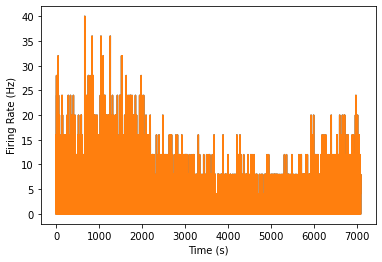

In [197]:
firing_rate, bin_location = spike_times_to_firing_rate(unit_spikes, window=250, stride=10, test_duration=None, progress_bar=True)
firing_rate_2, bin_location = spike_times_to_firing_rate_2(unit_spikes, window=250, stride=10, test_duration=None, progress_bar=True)
# indices = np.logical_and(bin_location < 4500, bin_location > 4000)
# indices = np.arange(len(firing_rate))
# plt.plot(bin_location[indices], firing_rate[indices])
plt.plot(bin_location, firing_rate)
plt.plot(bin_location, firing_rate_2)
plt.xlabel('Time (s)')
plt.ylabel('Firing Rate (Hz)')
plt.show()

In [198]:
np.array_equal(firing_rate, firing_rate_2)

True

### Check if there are Air Puffs during drug administration

In [246]:
smpInterval = f['lfpSchema']['smpInterval'][0, 0]

In [217]:
ain_index = []
for item in f[f['ainSchema']['index'][1, 0]][:, 0]:
    ain_index.append(to_string(item, f))
    print(ain_index[-1])

Mary-Anesthesia-20160809-01.reward
Mary-Anesthesia-20160809-01.eyePosX
Mary-Anesthesia-20160809-01.eyePosY
Mary-Anesthesia-20160809-01.pupilSize
Mary-Anesthesia-20160809-01.drugInfusion
Mary-Anesthesia-20160809-01.bar
Mary-Anesthesia-20160809-01.audio
Mary-Anesthesia-20160809-01.airPuff
Mary-Anesthesia-20160809-01.EEG
Mary-Anesthesia-20160809-01.EMG
Mary-Anesthesia-20160809-01.EEGbipolar
Mary-Anesthesia-20160809-01.cereStim
Mary-Anesthesia-20160809-01.SpO2
Mary-Anesthesia-20160809-01.heartRate
Mary-Anesthesia-20160809-01.cereStim_PPCSTG


In [218]:
def get_analog_chnl(f, chnl):
    ain_index = []
    for item in f[f['ainSchema']['index'][1, 0]][:, 0]:
        ain_index.append(to_string(item, f))
    chnl_index = np.argmax(np.array(ain_index) == f"{to_string(f['sessionInfo']['session'], f)}.{chnl}")
    
    return f['ain'][chnl_index]

In [226]:
airPuff = get_analog_chnl(f, 'airPuff')

In [232]:
drug_phase_1 = np.array([f['sessionInfo']['drugStart'][0, 0], f['sessionInfo']['drugEnd'][0, 0]])
drug_phase_2 = np.array([f['sessionInfo']['drugStart'][1, 0], f['sessionInfo']['drugEnd'][1, 0]])

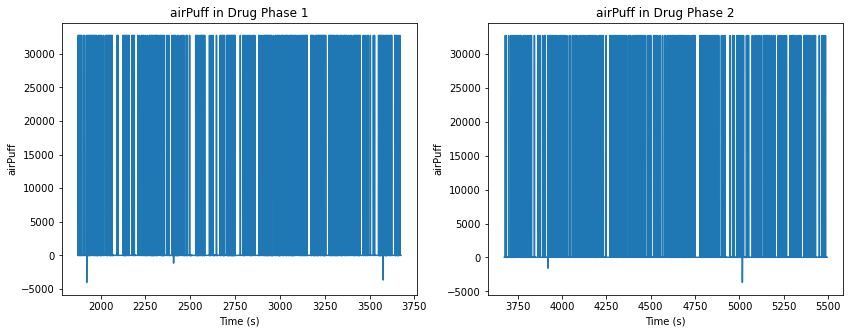

In [262]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
start_step = int(np.round(drug_phase_1[0]/smpInterval))
end_step = int(np.round(drug_phase_1[1]/smpInterval))
time = np.linspace(drug_phase_1[0], drug_phase_1[1], end_step - start_step)
plt.plot(time, airPuff[start_step:end_step])
plt.xlabel('Time (s)')
plt.ylabel('airPuff')
plt.title('airPuff in Drug Phase 1')


plt.subplot(1, 2, 2)
start_step = int(np.round(drug_phase_2[0]/smpInterval))
end_step = int(np.round(drug_phase_2[1]/smpInterval))
time = np.linspace(drug_phase_2[0], drug_phase_2[1], end_step - start_step)
plt.plot(time, airPuff[start_step:end_step])
plt.xlabel('Time (s)')
plt.ylabel('airPuff')
plt.title('airPuff in Drug Phase 2')

plt.show()